In [1]:
import time
import scipy
import numpy as np
import xarray as xr
import cmocean as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from gsw import f
from pathlib import Path
from scipy.optimize import fsolve
from dask.distributed import Client

In [2]:
def bc(ya,yb):
    return np.array([ya[0],ya[1] - 0.05])

def fun(z,phi,**kwargs):
    k = kwargs["k"]
    N = kwargs["N"]
    Ninterp = N.interp(zl = z)
    NN = (Ninterp[0:len(z)]**2).values
    return np.vstack((phi[1],-k**2 * NN * phi[0]))

def knGuess(N,n):
    return np.pi * n / N.integrate("zl").values

def _iterator(k,soln = False,**kwargs):
    # print(k,end = "\t")

    N = kwargs["N"]
    z = N.zl.values

    z = N.zl.values

    phi = np.zeros((2,z.size))
    x_plot = np.linspace(0, N.zl.values[-1], 100)
    sol = scipy.integrate.solve_bvp(
        lambda z,phi: fun(z,phi,k = k,N = N),
        bc,
        z,
        phi
        )
    y_plot = sol.sol(x_plot)[0]

    if soln:
        return sol

    # print(y_plot[-1])
    return y_plot[-1]

In [3]:
def ShootingVmodes(data,f,H = 5000,nmodes = 5):
    """
    Calculates vertical modes of both U and W. Fixes top boundary conditions as W(0) = 0, W'(0) = 1. Tweaks k until W(H) = 0.

    N : xarray.DataArray. Smoothed buoyancy frequency profile. Must be on the zl grid.
    H : float. Depth of the water column.
    nmodes : int. Number of modes to calculate.

    returns:
    xarray.Dataset containing U and W eigenfunctions 
    """
    ## First need to handle for the case where we're running this on 3D data rather than single water column!
    # data = data.drop_vars(["xb","yb"])
    try:
        # N = data.N.isel(xb = 0,yb = 0).drop_vars(["xb","yb"])
        # H = data.H.isel(xb = 0,yb = 0).drop_vars(["xb","yb"]).fillna(0).values
        # N = data.N
        N = data

        # N is on the zl grid. First add surface and seafloor values.
        N_trunc = N.sel(zl = slice(0,H))
        N_extend = np.zeros(N_trunc.shape[0] + 2)
        z_extend = np.zeros(N_extend.shape[0])
        z_extend[1:len(z_extend) - 1] = N_trunc.zl.values
        N_extend[1:len(z_extend) - 1] = N_trunc.values
        N_extend[0] = N_extend[1]
        N_extend[-1] = N_extend[-2]
        z_extend[0] = 0
        z_extend[-1] = H

        N_extend = xr.DataArray(N_extend,dims = "zl",coords = {"zl":z_extend})
        # f,M2 = 1/(17 * 3600), (28.984104 / 360) / (3600)
        M2 = 2 * np.pi / (12.4206014*3600)

        # Now N spans the entire water column allowing for accurate boundary conditions
        if not N_extend.integrate("zl") == 0: ## Check that N isn't all zeros
            ks = [
                fsolve(
                lambda x:_iterator(x,soln = False,N = N_extend),
                [knGuess(N_extend,i)],
                maxfev = 10
            )[0] for i in range(1,nmodes+1)]

            efuncs = []
            W = (N * 0).expand_dims({"mode":nmodes})
            for i,k in enumerate(ks):
                soln = _iterator(k,soln = True,N = N_extend)
                Weigenfunc = xr.DataArray(
                    soln.sol(soln.x)[0],
                    dims = ["z_l"],
                    coords = {"z_l":soln.x}
                )
                Weigenfunc = Weigenfunc / (np.sqrt((Weigenfunc**2).integrate("z_l")))
                # Ueigenfunc = Weigenfunc.differentiate("z_l").interp(z_l = N.zl.values).fillna(0).rename({"z_l":"zl"})
                Ueigenfunc = Weigenfunc.differentiate("z_l")
                Ueigenfunc = Ueigenfunc / (np.sqrt((Ueigenfunc**2).integrate("z_l")))

                Ueigenfunc = Ueigenfunc.interp(z_l = N.zl.values).fillna(0).rename({"z_l":"zl"})
                Weigenfunc = Weigenfunc.interp(z_l = N.zl.values).fillna(0).rename({"z_l":"zl"})


                ## Now calculate the actual k from dispersion relation. Divide by sqrt(M2^2 - f^2)
                
                k *= np.sqrt(M2**2 - f**2)
                h_wavelength = Ueigenfunc.isel(zl = 0).drop_vars(["zl"]).rename("Wavelength") * 0 + 1e-3/k 

                efuncs.append(xr.merge([Ueigenfunc.rename("U"),Weigenfunc.rename("W"),h_wavelength]).assign_coords({"mode":i}).expand_dims("mode"))


            efuncs = xr.concat(efuncs,dim = "mode")
            efuncs.mode.attrs["units"] = "km"
            efuncs.mode.attrs["short name"] = "Horizontal wavelength"
            # assert "xb" not in efuncs
            # efuncs = efuncs.expand_dims({"xb":data.xb.values,"yb":data.yb.values})
            # These efuncs now contain polynomial spline objects. 
            # They should be used to generate both the vertical and horizontal eigenfunctions zi and zl points

            # return efuncs[["U","W","Wavelength"]].transpose("mode","zl","yb","xb")
            return efuncs[["U","W","Wavelength"]].transpose("mode","zl")
        
        else:
            ## In this case we return a dummy values with the right shape
            # Ueigenfunc = xr.DataArray(
            #     N.zl.values * 0,
            #     dims = ["zl"],
            #     coords = {"zl":N.zl.values}
            # ).rename("U").expand_dims({"xb":data.xb.values,"yb":data.yb.values,"mode":np.arange(nmodes)}).transpose("mode","zl","yb","xb")
            Ueigenfunc = xr.DataArray(
                N.zl.values * 0,
                dims = ["zl"],
                coords = {"zl":N.zl.values}
            ).rename("U").expand_dims({"mode":np.arange(nmodes)}).transpose("mode","zl")
            h_wavelength = Ueigenfunc.isel(zl = 0).drop_vars(["zl"]).rename("Wavelength")
            return xr.merge([Ueigenfunc,Ueigenfunc.rename("W"),h_wavelength])
        
    except Exception as e:

        raise ValueError(f" Error at xb = {data.lon.values} yb = {data.lat.values} \n\n\n {e}")

In [4]:
N_data = xr.open_dataset('/g/data/nm03/lxy581/WOA18/N3D_prof_woa18.nc')
rho_data = xr.open_dataset('/g/data/nm03/lxy581/WOA18/woa18_decav_I00_04.nc',decode_times=False)

In [5]:
N_data

<xarray.Dataset> Size: 838MB
Dimensions:  (depth: 101, lat: 720, lon: 1440)
Coordinates:
  * depth    (depth) float32 404B 2.5 7.5 12.5 ... 5.25e+03 5.35e+03 5.45e+03
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Data variables:
    N        (depth, lat, lon) float64 838MB ...

In [6]:
N_data.N

<xarray.DataArray 'N' (depth: 101, lat: 720, lon: 1440)> Size: 838MB
[104716800 values with dtype=float64]
Coordinates:
  * depth    (depth) float32 404B 2.5 7.5 12.5 ... 5.25e+03 5.35e+03 5.45e+03
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9

In [7]:
N_data = N_data.rename({'depth': 'zl'})
rho_data = rho_data.rename({'depth': 'zl'})

In [8]:
lats = N_data.lat
f_all = f(lats)
M2 = 2 * np.pi / (12.4206014*3600)
valid_lat = f_all**2 <= M2**2

In [9]:
valid_lat.isel(lat=62)

<xarray.DataArray 'lat' ()> Size: 1B
array(True)
Coordinates:
    lat      float32 4B -74.38

In [10]:
lats.isel(lat=61)

<xarray.DataArray 'lat' ()> Size: 4B
array(-74.625, dtype=float32)
Coordinates:
    lat      float32 4B -74.62

In [11]:
valid_lat.isel(lat=-63)

<xarray.DataArray 'lat' ()> Size: 1B
array(True)
Coordinates:
    lat      float32 4B 74.38

In [12]:
lats.isel(lat=-63)

<xarray.DataArray 'lat' ()> Size: 4B
array(74.375, dtype=float32)
Coordinates:
    lat      float32 4B 74.38

In [13]:
valid = N_data.N.notnull()
max_depth = N_data.zl.where(valid).max("zl")

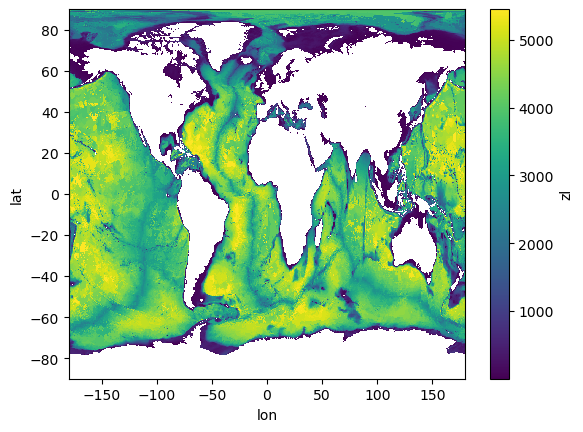

In [14]:
max_depth.plot()

In [15]:
mask = (abs(N_data.lat) < 74.4) & (max_depth > 1000)
N_profile = N_data.N.where(mask).mean(("lat", "lon"), skipna=True)

In [16]:
N_profile

<xarray.DataArray 'N' (zl: 101)> Size: 808B
array([0.0046955 , 0.00541988, 0.00494313, 0.00545837, 0.00631927,
       0.00693901, 0.00773888, 0.00826749, 0.00868889, 0.0088764 ,
       0.00915546, 0.00925144, 0.00932366, 0.00928978, 0.00923   ,
       0.00916694, 0.00911105, 0.00896596, 0.00888486, 0.00870473,
       0.00821542, 0.00738002, 0.00656206, 0.00586314, 0.00526299,
       0.00482691, 0.00445517, 0.00418658, 0.00397372, 0.00378084,
       0.00363334, 0.00350074, 0.0033704 , 0.00325776, 0.00316063,
       0.00308924, 0.0029582 , 0.00282345, 0.00272095, 0.00267637,
       0.00260754, 0.00256122, 0.00251005, 0.00251199, 0.00240517,
       0.00233352, 0.00226518, 0.00219857, 0.00212989, 0.00205872,
       0.00199547, 0.00193903, 0.00187197, 0.00180933, 0.0017524 ,
       0.00170409, 0.00170194, 0.00159691, 0.00154281, 0.00149484,
       0.00144637, 0.00139854, 0.0013529 , 0.00131052, 0.00126341,
       0.00135649, 0.00122233, 0.00110198, 0.00103607, 0.00098391,
       0.00092618, 0.00087974, 0.0008471 , 0.00082485, 0.00079434,
       0.00078148, 0.00075965, 0.00073837, 0.00073148, 0.00071633,
       0.0007144 , 0.00068725, 0.00067565, 0.00066172, 0.00064374,
       0.00064873, 0.00061061, 0.00058328, 0.00056165, 0.00052952,
       0.00049619, 0.00046155, 0.00042711, 0.00040055, 0.00041227,
       0.00042022, 0.00041778, 0.00048253, 0.00045503, 0.00042761,
       0.0005709 ])
Coordinates:
  * zl       (zl) float32 404B 2.5 7.5 12.5 17.5 ... 5.25e+03 5.35e+03 5.45e+03

In [17]:
f_loc = f(45)
eigenfuncs = ShootingVmodes(N_profile,f_loc,H=N_profile.zl.isel(zl=-1)+1,nmodes = 3)
eigenfuncs

<xarray.Dataset> Size: 5kB
Dimensions:     (mode: 3, zl: 101)
Coordinates:
  * mode        (mode) int64 24B 0 1 2
  * zl          (zl) float32 404B 2.5 7.5 12.5 ... 5.25e+03 5.35e+03 5.45e+03
Data variables:
    U           (mode, zl) float64 2kB 0.04216 0.04216 ... -0.01028 -0.0103
    W           (mode, zl) float64 2kB 7.141e-05 0.0002142 ... 1.402e-05
    Wavelength  (mode) float64 24B 24.8 12.88 9.103

Start plotting...
0
1
2


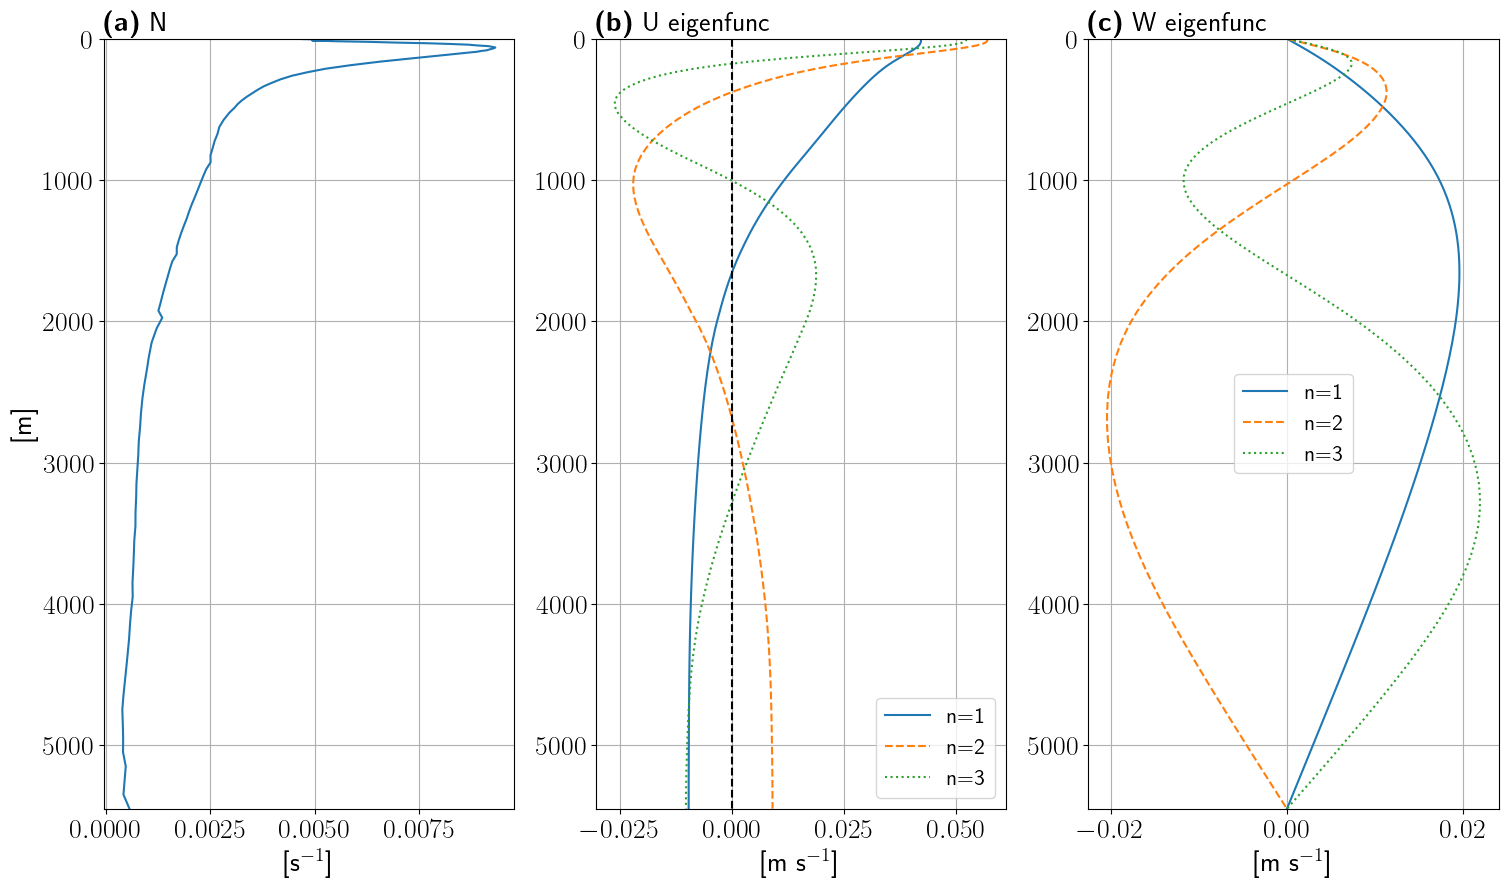

In [18]:
# Enable LaTeX text rendering
plt.rc('text', usetex=True)

title = [r'\textbf{(a)} N', 
         r'\textbf{(b)} U eigenfunc', 
         r'\textbf{(c)} W eigenfunc']

fig = plt.figure(figsize=(18, 10))
axs = []

gridsubs = gridspec.GridSpec(1,3)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

print('Start plotting...')
for I, ax in enumerate(axs):
    print(I)

    ax.tick_params(labelsize=20)
    ax.set_title(title[I],fontsize=20,loc="left")

    if I==0:
        ax.plot(N_profile,N_profile.zl)
        ax.set_ylim(0,N_profile.zl.isel(zl=-1))
        ax.set_ylabel('[m]',fontsize=20)
        ax.set_xlabel('[s$^{-1}$]',fontsize=20)
        ax.invert_yaxis()
        ax.grid(True)

    if I==1:
        ax.plot(eigenfuncs.sel(mode=0).U,N_profile.zl,label='n=1')
        ax.plot(eigenfuncs.sel(mode=1).U,N_profile.zl,linestyle='--',label='n=2')
        ax.plot(eigenfuncs.sel(mode=2).U,N_profile.zl,linestyle=':',label='n=3')
        ax.plot([0,0],[0,N_profile.zl.isel(zl=-1)],'k--')
        ax.set_ylim(0,N_profile.zl.isel(zl=-1))
        ax.set_xlabel('[m s$^{-1}$]',fontsize=20)
        ax.invert_yaxis()
        ax.legend(loc=0,fontsize=16)
        ax.grid(True)
        
    if I==2:
        ax.plot(eigenfuncs.sel(mode=0).W,N_profile.zl,label='n=1')
        ax.plot(eigenfuncs.sel(mode=1).W,N_profile.zl,linestyle='--',label='n=2')
        ax.plot(eigenfuncs.sel(mode=2).W,N_profile.zl,linestyle=':',label='n=3')
        ax.set_ylim(0,N_profile.zl.isel(zl=-1))
        ax.set_xlabel('[m s$^{-1}$]',fontsize=20)
        ax.invert_yaxis()
        ax.legend(loc=0,fontsize=16)
        ax.grid(True)

#### Get the zero-crossing depth of mode-1

In [19]:
U_mode1 = np.array(eigenfuncs.sel(mode=0).U)
D_mode1 = np.array(N_profile.zl)
i = np.where(np.diff(np.sign(U_mode1)))[0][0]
inter_h = np.interp(0, U_mode1[i:i+2], D_mode1[i:i+2])
print('Zero-crossing depth is %.1f m'%inter_h)

Zero-crossing depth is 1675.0 m


#### Average density above and below the zero-crossing depth

In [20]:
rho_profile = rho_data.I_an.where(mask).mean(("lat", "lon"), skipna=True)

In [21]:
rho_profile

<xarray.DataArray 'I_an' (time: 1, zl: 102)> Size: 408B
array([[24.875023, 24.90636 , 24.941025, 24.982504, 25.028854, 25.084082,
        25.145847, 25.215906, 25.290731, 25.369846, 25.44981 , 25.53218 ,
        25.614727, 25.698246, 25.779877, 25.860954, 25.941156, 26.020462,
        26.098343, 26.175245, 26.249525, 26.598888, 26.905209, 27.172276,
        27.406818, 27.615911, 27.809565, 27.990026, 28.162218, 28.328142,
        28.489311, 28.6466  , 28.800354, 28.950974, 29.09938 , 29.245289,
        29.389198, 29.672142, 29.950348, 30.22512 , 30.498169, 30.769466,
        31.03956 , 31.308231, 31.576256, 31.84148 , 32.10453 , 32.365856,
        32.625134, 32.882526, 33.138065, 33.392056, 33.645683, 33.896664,
        34.14625 , 34.394363, 34.64129 , 34.887177, 35.13188 , 35.375607,
        35.618206, 35.859894, 36.100708, 36.340828, 36.579952, 36.818348,
        37.05725 , 37.533443, 38.007988, 38.47684 , 38.94322 , 39.407536,
        39.870335, 40.33154 , 40.7916  , 41.25022 , 41.707973, 42.16492 ,
        42.62101 , 43.07633 , 43.53104 , 43.98489 , 44.437782, 44.889748,
        45.340794, 45.790646, 46.24017 , 46.68809 , 47.1343  , 47.57847 ,
        48.021584, 48.462532, 48.901867, 49.33944 , 49.77496 , 50.210617,
        50.643024, 51.071873, 51.49697 , 51.91806 , 52.339817, 52.764355]],
      dtype=float32)
Coordinates:
  * time     (time) float32 4B 4.326e+03
  * zl       (zl) float32 408B 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03

In [22]:
rho_up = rho_profile.where(rho_profile.zl <= inter_h, drop=True)
rho_up_mean = (rho_up.integrate('zl') / (rho_up.zl.max() - rho_up.zl.min()))
print(rho_up_mean[0].values)

30.969839015151514


In [23]:
rho_lo = rho_profile.where((rho_profile.zl > inter_h), drop=True)
rho_lo_mean = (rho_lo.integrate('zl') / (rho_lo.zl.max() - rho_lo.zl.min()))
print(rho_lo_mean[0].values)

44.36602796052632


#### Save as input files: coord.nc (densities for each layer) and vgrid.nc (z, zt, zw, dz)

In [24]:
rho_2layer = np.array([rho_up_mean[0].values,rho_lo_mean[0].values])+1000
ds_rho = xr.Dataset(data_vars={"Layer": (('nz'), rho_2layer),
                              },
                       coords={"nz": (('nz'), np.arange(2)),
                              })
ds_rho.to_netcdf('/g/data/nm03/lxy581/input/tides_8km_2_layer/coord.nc')

In [25]:
topog = xr.open_dataset('/g/data/nm03/lxy581/input/tides_008deg_drag_coeff/ocean_topog.nc')
topog.depth.max().values

array(10521.41503906)

In [26]:
N_profile.zl.isel(zl=-1)

<xarray.DataArray 'zl' ()> Size: 4B
array(5450., dtype=float32)
Coordinates:
    zl       float32 4B 5.45e+03

In [27]:
zw = np.array([0,inter_h,5500])
zt = np.array([inter_h/2,(inter_h+5500)/2])
z = -zt
dz = np.array([inter_h,5500-inter_h])

In [28]:
print(zw)
print(zt)
print(z)
print(dz)

[   0. 1675. 5500.]
[ 837.5 3587.5]
[ -837.5 -3587.5]
[1675. 3825.]


In [29]:
ds_z = xr.Dataset(data_vars={"dz": (('nz'), dz),
                             "z": (('nz'), z),
                             "zt": (('nz'), zt),
                             "zw": (('nzw'), zw),
                              },
                       coords={"nz": (('nz'), np.arange(2)),
                               "nzw": (('nzw'), np.arange(3)),
                              })
ds_z.to_netcdf('/g/data/nm03/lxy581/input/tides_8km_2_layer/vgrid.nc')

#### 2-layer:
* interface height: 1675 m
* top layer density: 1030.969839015151514 kg m-3
* bottom layer density: 1044.36602796052632 kg m-3

#### Get the zero-crossing depth of mode-2

In [30]:
U_mode2 = np.array(eigenfuncs.sel(mode=1).U)
D_mode2 = np.array(N_profile.zl)

In [31]:
idx = np.where(np.diff(np.sign(U_mode2)) != 0)[0]
idx

array([30, 72])

In [32]:
inter_h_mode2 = []

In [33]:
for i in idx:
    zc = np.interp(0, U_mode2[i:i+2], D_mode2[i:i+2])
    inter_h_mode2.append(zc)

for n, zc in enumerate(inter_h_mode2, 1):
    print(f"Zero-crossing depth ({n}) is {zc:.1f} m")

Zero-crossing depth (1) is 387.5 m
Zero-crossing depth (2) is 2690.4 m


In [34]:
inter_h_mode2

[387.5, 2690.3926529726323]

In [35]:
# Layer 1 (top) 
rho_L1 = rho_profile.where(rho_profile.zl <= inter_h_mode2[0], drop=True)
rho_L1_mean = rho_L1.integrate("zl") / (rho_L1.zl.max() - rho_L1.zl.min())

# Layer 2 (middle) 
rho_L2 = rho_profile.where((rho_profile.zl > inter_h_mode2[0]) & (rho_profile.zl <= inter_h_mode2[1]), drop=True)
rho_L2_mean = rho_L2.integrate("zl") / (rho_L2.zl.max() - rho_L2.zl.min())

# Layer 3 (bottom)
rho_L3 = rho_profile.where(rho_profile.zl > inter_h_mode2[1], drop=True)
rho_L3_mean = rho_L3.integrate("zl") / (rho_L3.zl.max() - rho_L3.zl.min())

print("Layer 1 mean density:", rho_L1_mean[0].values)
print("Layer 2 mean density:", rho_L2_mean[0].values)
print("Layer 3 mean density:", rho_L3_mean[0].values)

Layer 1 mean density: 27.0577421875
Layer 2 mean density: 34.54340553977273
Layer 3 mean density: 46.641311383928574


#### Save as input files: coord.nc (densities for each layer) and vgrid.nc (z, zt, zw, dz)

In [36]:
rho_3layer = np.array([rho_L1_mean[0].values,rho_L2_mean[0].values,rho_L3_mean[0].values])+1000
ds_rho = xr.Dataset(data_vars={"Layer": (('nz'), rho_3layer),
                              },
                       coords={"nz": (('nz'), np.arange(3)),
                              })
ds_rho.to_netcdf('/g/data/nm03/lxy581/input/tides_8km_3_layer/coord.nc')

In [37]:
zw = np.array([0,inter_h_mode2[0],inter_h_mode2[1],5500])
zt = np.array([inter_h_mode2[0]/2,(inter_h_mode2[0]+inter_h_mode2[1])/2,(inter_h_mode2[1]+5500)/2])
z = -zt
dz = np.array([inter_h_mode2[0],inter_h_mode2[1]-inter_h_mode2[0],5500-inter_h_mode2[1]])

ds_z = xr.Dataset(data_vars={"dz": (('nz'), dz),
                             "z": (('nz'), z),
                             "zt": (('nz'), zt),
                             "zw": (('nzw'), zw),
                              },
                       coords={"nz": (('nz'), np.arange(3)),
                               "nzw": (('nzw'), np.arange(4)),
                              })
ds_z.to_netcdf('/g/data/nm03/lxy581/input/tides_8km_3_layer/vgrid.nc')

#### 3-layer:
* interface heights: 387.5 m, 2690.4 m
* layer 1 density: 1027.0577421875 kg m-3
* layer 2 density: 1034.54340553977273 kg m-3
* layer 3 density: 1046.641311383928574 kg m-3

#### Get the zero-crossing depth of mode-3

In [38]:
U_mode3 = np.array(eigenfuncs.sel(mode=2).U)
D_mode3 = np.array(N_profile.zl)

In [39]:
idx = np.where(np.diff(np.sign(U_mode3)) != 0)[0]
idx

array([22, 45, 78])

In [40]:
inter_h_mode3 = []

In [41]:
for i in idx:
    zc = np.interp(0, U_mode3[i:i+2], D_mode3[i:i+2])
    inter_h_mode3.append(zc)

for n, zc in enumerate(inter_h_mode3, 1):
    print(f"Zero-crossing depth ({n}) is {zc:.1f} m")

Zero-crossing depth (1) is 187.5 m
Zero-crossing depth (2) is 1006.0 m
Zero-crossing depth (3) is 3350.0 m


In [42]:
inter_h_mode3

[187.5, 1006.0045892422902, 3350.0]

In [43]:
# Layer 1 (top) 
rho_L1 = rho_profile.where(rho_profile.zl <= inter_h_mode3[0], drop=True)
rho_L1_mean = rho_L1.integrate("zl") / (rho_L1.zl.max() - rho_L1.zl.min())

# Layer 2 (middle) 
rho_L2 = rho_profile.where((rho_profile.zl > inter_h_mode3[0]) & (rho_profile.zl <= inter_h_mode3[1]), drop=True)
rho_L2_mean = rho_L2.integrate("zl") / (rho_L2.zl.max() - rho_L2.zl.min())

# Layer 3 (middle) 
rho_L3 = rho_profile.where((rho_profile.zl > inter_h_mode3[1]) & (rho_profile.zl <= inter_h_mode3[2]), drop=True)
rho_L3_mean = rho_L3.integrate("zl") / (rho_L3.zl.max() - rho_L3.zl.min())

# Layer 4 (bottom)
rho_L4 = rho_profile.where(rho_profile.zl > inter_h_mode3[2], drop=True)
rho_L4_mean = rho_L4.integrate("zl") / (rho_L4.zl.max() - rho_L4.zl.min())

print("Layer 1 mean density:", rho_L1_mean[0].values)
print("Layer 2 mean density:", rho_L2_mean[0].values)
print("Layer 3 mean density:", rho_L3_mean[0].values)
print("Layer 4 mean density:", rho_L4_mean[0].values)

Layer 1 mean density: 26.022101004464286
Layer 2 mean density: 29.8997216796875
Layer 3 mean density: 37.834069444444445
Layer 4 mean density: 48.21015625


#### Save as input files: coord.nc (densities for each layer) and vgrid.nc (z, zt, zw, dz)

In [44]:
rho_4layer = np.array([rho_L1_mean[0].values,rho_L2_mean[0].values,rho_L3_mean[0].values,rho_L4_mean[0].values])+1000
ds_rho = xr.Dataset(data_vars={"Layer": (('nz'), rho_4layer),
                              },
                       coords={"nz": (('nz'), np.arange(4)),
                              })
ds_rho.to_netcdf('/g/data/nm03/lxy581/input/tides_8km_4_layer/coord.nc')

In [45]:
zw = np.array([0,inter_h_mode3[0],inter_h_mode3[1],inter_h_mode3[2],5500])
zt = np.array([inter_h_mode3[0]/2,(inter_h_mode3[0]+inter_h_mode3[1])/2,(inter_h_mode3[1]+inter_h_mode3[2])/2,(inter_h_mode3[2]+5500)/2])
z = -zt
dz = np.array([inter_h_mode3[0],inter_h_mode3[1]-inter_h_mode3[0],inter_h_mode3[2]-inter_h_mode3[1],5500-inter_h_mode3[2]])

ds_z = xr.Dataset(data_vars={"dz": (('nz'), dz),
                             "z": (('nz'), z),
                             "zt": (('nz'), zt),
                             "zw": (('nzw'), zw),
                              },
                       coords={"nz": (('nz'), np.arange(4)),
                               "nzw": (('nzw'), np.arange(5)),
                              })
ds_z.to_netcdf('/g/data/nm03/lxy581/input/tides_8km_4_layer/vgrid.nc')

#### 4-layer:
* interface heights: 187.5 m, 1006.0 m, 3350.0 m
* layer 1 density: 1026.022101004464286 kg m-3
* layer 2 density: 1029.8997216796875 kg m-3
* layer 3 density: 1037.834069444444445 kg m-3
* layer 4 density: 1048.21015625 kg m-3

#### create a mask to exclude shallow ocean and poleward of critical latitude???